# MADGAN Implementation

This notebook implements MADGAN (Multiple Discriminator GANs) on the CIFAR-10 dataset using PyTorch. Each step is explained with detailed comments to serve as a reference for future projects.

In [1]:

# Import essential libraries
import torch                              # Core PyTorch library for deep learning
import torch.nn as nn                     # For building neural networks
import torch.optim as optim               # For optimization algorithms
from torchvision import datasets, transforms  # To handle datasets and data transformations
from torch.utils.data import DataLoader   # To efficiently load data into batches
import matplotlib.pyplot as plt           # For plotting and visualizing images
import numpy as np                        # For numerical operations


In [2]:

# Define hyperparameters for the MADGAN model
latent_dim = 128            # Size of the random noise vector for the generator
image_size = 32             # Image size (32x32 for CIFAR-10)
image_channels = 3          # CIFAR-10 images have 3 channels (RGB)
batch_size = 64             # Number of samples per batch
epochs = 50                 # Number of training epochs
learning_rate = 0.0002      # Learning rate for the optimizer
num_discriminators = 3      # Number of discriminators in MADGAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available


In [3]:
# Define data transformations: normalize images to range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),       # Normalize RGB channels to mean 0.5
                         (0.5, 0.5, 0.5))       # and standard deviation 0.5
])

# Load the CIFAR-10 dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Create a DataLoader to handle data batching and shuffling
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,            # Use 4 worker threads (adjust as per your system capabilities)
    pin_memory=True,          # Enable pinned memory if using GPU
    persistent_workers=True   # Reduce worker initialization overhead for long sessions
)


In [4]:
# Check the transformation applied to the dataset
# Modify the normalization transformation for MNIST (single channel)
dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Correct normalization for grayscale (1 channel)
])

# Now, you can continue with the dataloader as before
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,           # Use 4 worker threads (adjust based on your system)
    pin_memory=True,         # Enable pinned memory if using GPU
    persistent_workers=True  # Reduce worker initialization overhead for long sessions
)


In [5]:

class Generator(nn.Module):
    def __init__(self, latent_dim, image_channels, image_size):
        super(Generator, self).__init__()
        # Define a fully connected neural network for the generator
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),              # Map latent space to 256 features
            nn.ReLU(True),                           # Use ReLU activation for non-linearity
            nn.Linear(256, 512),                     # Expand to 512 features
            nn.ReLU(True),                           # Apply ReLU again
            nn.Linear(512, 1024),                    # Expand further to 1024 features
            nn.ReLU(True),                           # Continue with ReLU activation
            nn.Linear(1024, image_channels * image_size * image_size),  # Output full-sized image
            nn.Tanh()                                # Use Tanh to map output to range [-1, 1]
        )
    
    def forward(self, z):
        # Forward pass: reshape the linear output into an image format
        return self.net(z).view(z.size(0), image_channels, image_size, image_size)

# Instantiate the generator and move it to the device (GPU/CPU)
generator = Generator(latent_dim, image_channels, image_size).to(device)


In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, img_size):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, img_channels * img_size * img_size)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()  # To ensure output is between -1 and 1

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        # Reshape the output to the image size (batch_size, channels, height, width)
        return self.tanh(x).view(-1, 1, 28, 28)  # MNIST image size (1, 28, 28)


In [6]:
# class Generator(nn.Module):
#     def __init__(self, latent_dim, channels, img_size):
#         super(Generator, self).__init__()
#         # latent_dim: Dimensionality of the latent vector z (input noise)
#         # channels: Number of output channels (1 for grayscale MNIST images)
#         # img_size: Size of the output image (28 for MNIST)
        
#         self.img_size = img_size  # Image size (28x28 for MNIST)
#         self.channels = channels  # Number of channels (1 for grayscale images)
#         self.latent_dim = latent_dim  # Latent dimension (size of input noise vector)

#         # Fully connected layer to transform the latent vector z to a larger feature map
#         # The latent vector z will be reshaped to an intermediate feature space (256 neurons)
#         self.fc = nn.Linear(self.latent_dim, 256)  

#         # Further transformations to increase feature complexity
#         self.fc2 = nn.Linear(256, 512)
#         self.fc3 = nn.Linear(512, 1024)

#         # Final fully connected layer to reshape the feature map to the image size (28x28)
#         # We want the output to be 28x28 pixels, and with 1 channel (grayscale), so channels*img_size*img_size = 1 * 28 * 28
#         self.fc4 = nn.Linear(1024, self.channels * self.img_size * self.img_size)
        
#         # Activation functions
#         self.relu = nn.ReLU(True)  # ReLU is used to add non-linearity
#         self.tanh = nn.Tanh()      # Tanh ensures output values are in the range [-1, 1] for image generation

#     def forward(self, z):
#         # Forward pass through the layers

#         # First fully connected layer with ReLU activation
#         z = self.relu(self.fc(z))
        
#         # Second fully connected layer with ReLU activation
#         z = self.relu(self.fc2(z))
        
#         # Third fully connected layer with ReLU activation
#         z = self.relu(self.fc3(z))

#         # Final layer to reshape the output to the image size (28x28 pixels, 1 channel)
#         z = self.fc4(z)
        
#         # Reshape the output to the shape of the desired image (batch_size, 1, 28, 28)
#         z = z.view(-1, self.channels, self.img_size, self.img_size)
        
#         # Apply Tanh activation to bring pixel values in the range [-1, 1]
#         return self.tanh(z)


In [7]:

class Discriminator(nn.Module):
    def __init__(self, image_channels, image_size):
        super(Discriminator, self).__init__()
        # Define a fully connected neural network for the discriminator
        self.net = nn.Sequential(
            nn.Linear(image_channels * image_size * image_size, 1024),  # Flatten input
            nn.LeakyReLU(0.2, inplace=True),                           # Use LeakyReLU activation
            nn.Linear(1024, 512),                                     # Reduce to 512 features
            nn.LeakyReLU(0.2, inplace=True),                           # Continue with LeakyReLU
            nn.Linear(512, 256),                                      # Further reduce to 256 features
            nn.LeakyReLU(0.2, inplace=True),                           # Apply LeakyReLU again
            nn.Linear(256, 1),                                        # Single output: probability of being real
            nn.Sigmoid()                                              # Sigmoid for output between [0, 1]
        )
    
    def forward(self, x):
        # Forward pass: flatten the input and apply the network
        x = x.view(x.size(0), -1)  # Flatten the image
        return self.net(x)

# Instantiate multiple discriminators and move them to the device
discriminators = [Discriminator(image_channels, image_size).to(device) for _ in range(num_discriminators)]


In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()
        
        self.img_size = img_size  # Image size (28x28 for MNIST)
        self.channels = channels  # Number of input channels (1 for grayscale)

        # Adjust the first fully connected layer to accept 784 features (28x28 for MNIST)
        self.fc1 = nn.Linear(self.channels * self.img_size * self.img_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)  # Final output layer for binary classification (real or fake)

        # Activation functions
        self.relu = nn.LeakyReLU(0.2, inplace=True)  # LeakyReLU with a negative slope of 0.2
        self.sigmoid = nn.Sigmoid()  # Sigmoid to output probabilities between 0 and 1

    def forward(self, x):
        # Flatten the image from (batch_size, channels, img_size, img_size) to (batch_size, channels*img_size*img_size)
        x = x.view(x.size(0), -1)  # Flatten the image to a 1D vector

        # Pass through fully connected layers with LeakyReLU activations
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))

        # Output layer with Sigmoid activation to predict if the image is real or fake (between 0 and 1)
        x = self.fc4(x)
        
        return self.sigmoid(x)  # Returns probability (0 = fake, 1 = real)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()
        
        self.img_size = img_size  # Image size (28x28 for MNIST)
        self.channels = channels  # Number of input channels (1 for grayscale)

        # Adjust the first fully connected layer to accept 784 features (28x28 for MNIST)
        self.fc1 = nn.Linear(self.channels * self.img_size * self.img_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)  # Final output layer for binary classification (real or fake)

        # Activation functions
        self.relu = nn.LeakyReLU(0.2, inplace=True)  # LeakyReLU with a negative slope of 0.2
        self.sigmoid = nn.Sigmoid()  # Sigmoid to output probabilities between 0 and 1

    def forward(self, x):
        # Flatten the image from (batch_size, channels, img_size, img_size) to (batch_size, channels*img_size*img_size)
        x = x.view(x.size(0), -1)  # Flatten the image to a 1D vector

        # Pass through fully connected layers with LeakyReLU activations
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))

        # Output layer with Sigmoid activation to predict if the image is real or fake (between 0 and 1)
        x = self.fc4(x)
        
        return self.sigmoid(x)  # Returns probability (0 = fake, 1 = real)


In [17]:

# Binary Cross Entropy Loss: measure the distance between predicted and actual probabilities
criterion = nn.BCELoss()

# Optimizer for the generator
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Separate optimizers for each discriminator
optimizers_D = [optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)) for discriminator in discriminators]


In [15]:
# For a single generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [18]:
# Assuming you already have the data loader and other components set up

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)  # Move real images to device
        batch_size = real_images.size(0)  # Get batch size

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the Discriminator
        optimizers_D.zero_grad()

        # Train on real images
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        
        # Train on fake images
        noise = torch.randn(batch_size, z_dim).to(device)  # Generate random noise for fake images
        fake_images = generator(noise)  # Generate fake images from the noise
        fake_outputs = discriminator(fake_images.detach())  # Detach fake images from the graph
        fake_loss = criterion(fake_outputs, fake_labels)
        
        # Total loss for the Discriminator
        d_loss = real_loss + fake_loss
        d_loss.backward()  # Backpropagate the loss
        optimizers_D.step()  # Update the Discriminator's weights

        # Train the Generator
        optimizers_G.zero_grad()

        # Try to fool the Discriminator with fake images
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # We want fake images to be classified as real
        g_loss.backward()  # Backpropagate the loss
        optimizers_G.step()  # Update the Generator's weights

    print(f"Epoch [{epoch}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


AttributeError: 'list' object has no attribute 'zero_grad'

In [10]:

for epoch in range(epochs):  # Loop through epochs
    for i, (real_images, _) in enumerate(dataloader):  # Loop through each batch
        # Move real images to the device (GPU/CPU)
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create real and fake labels for the current batch
        real_labels = torch.ones(batch_size, 1).to(device)  # Real images have label 1
        fake_labels = torch.zeros(batch_size, 1).to(device) # Fake images have label 0

        # Train each discriminator
        for d_idx, discriminator in enumerate(discriminators):
            optimizers_D[d_idx].zero_grad()  # Reset gradients for the discriminator
            
            # Train on real images
            real_outputs = discriminator(real_images)
            real_loss = criterion(real_outputs, real_labels)  # Loss for real images
            
            # Train on fake images
            z = torch.randn(batch_size, latent_dim).to(device)  # Generate random noise
            fake_images = generator(z)  # Generate fake images
            fake_outputs = discriminator(fake_images.detach())  # Detach to stop gradient flow
            fake_loss = criterion(fake_outputs, fake_labels)  # Loss for fake images
            
            # Combine real and fake loss, backpropagate, and update the discriminator
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizers_D[d_idx].step()

        # Train the generator
        optimizer_G.zero_grad()  # Reset gradients for the generator
        z = torch.randn(batch_size, latent_dim).to(device)  # Generate random noise
        fake_images = generator(z)  # Generate fake images
        
        # Fool all discriminators
        g_loss = 0
        for discriminator in discriminators:
            outputs = discriminator(fake_images)  # Get discriminator outputs
            g_loss += criterion(outputs, real_labels)  # Generator tries to fool discriminators
        g_loss /= num_discriminators  # Average loss across all discriminators
        
        # Backpropagate and update the generator
        g_loss.backward()
        optimizer_G.step()

        # Print progress every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x784 and 3072x1024)

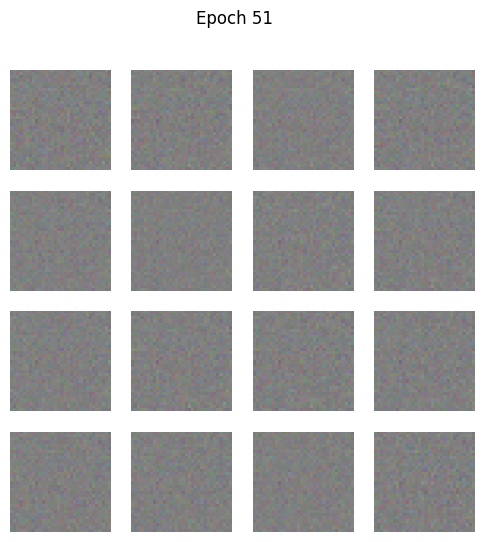

In [ ]:

# Function to generate and visualize fake images
def generate_and_save_images(generator, epoch, latent_dim, num_images=16):
    generator.eval()  # Set generator to evaluation mode
    z = torch.randn(num_images, latent_dim).to(device)  # Generate random noise
    fake_images = generator(z)  # Generate fake images
    fake_images = fake_images.cpu().detach().numpy()  # Detach from graph and move to CPU
    
    # Plot the generated images
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow((fake_images[i].transpose(1, 2, 0) + 1) / 2)  # De-normalize and plot
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch+1}")
    plt.show()

# Generate images after training
generate_and_save_images(generator, epochs, latent_dim)


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the Discriminator Model (CNN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)  # Input: 1x28x28 -> Output: 64x14x14
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # Input: 64x14x14 -> Output: 128x7x7
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)  # Flattened input size
        self.fc2 = nn.Linear(1024, 1)  # Output: 1 (real/fake)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Apply first convolution
        x = torch.relu(self.conv2(x))  # Apply second convolution
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 128*7*7)
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = torch.sigmoid(self.fc2(x))  # Output layer
        return x

# Define the Generator Model (for illustration)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 1024)  # Input: random noise (100) -> Output: 1024
        self.fc2 = nn.Linear(1024, 128 * 7 * 7)  # Output: 128*7*7 (same as flattened Conv2D output)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample
        self.conv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)  # Output image
        
    def forward(self, z):
        z = torch.relu(self.fc1(z))  # Apply first fully connected layer
        z = torch.relu(self.fc2(z))  # Apply second fully connected layer
        z = z.view(z.size(0), 128, 7, 7)  # Reshape into 128x7x7 (for ConvTranspose)
        z = torch.relu(self.conv1(z))  # Upsample
        z = torch.sigmoid(self.conv2(z))  # Final output (image)
        return z

# Set up dataset
transform = transforms.Compose([
    transforms.ToTensor(),   # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for MNIST
])

# Download and load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Create the models
discriminator = Discriminator()
generator = Generator()

# Optimizers
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop (simplified)
epochs = 10
z_dim = 100

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Move real images to the device (if using GPU)
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Zero the gradients
        optimizer_D.zero_grad()

        # Train on real images
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        
        # Generate fake images
        noise = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())  # Detach to avoid backprop into generator
        fake_loss = criterion(fake_outputs, fake_labels)

        # Total loss for discriminator
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()
        
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # Try to fool the discriminator
        
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch [0/10], D Loss: 7.855386741084658e-08, G Loss: 16.37076759338379
Epoch [1/10], D Loss: 1.2114975689314633e-08, G Loss: 18.231975555419922
Epoch [2/10], D Loss: 2.7619835307746143e-09, G Loss: 19.7086238861084
Epoch [3/10], D Loss: 2.2515540543111e-09, G Loss: 19.913164138793945
Epoch [4/10], D Loss: 1.1845867620152717e-09, G Loss: 20.555070877075195
Epoch [5/10], D Loss: 6.673374075560901e-10, G Loss: 21.12871551513672
Epoch [6/10], D Loss: 5.586434648208183e-10, G Loss: 21.306657791137695
Epoch [7/10], D Loss: 3.535234882612315e-10, G Loss: 21.764083862304688
Epoch [8/10], D Loss: 2.2782847830526975e-10, G Loss: 22.203311920166016
Epoch [9/10], D Loss: 1.7570206400918664e-10, G Loss: 22.46312713623047


In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(100, 128 * 7 * 7)  # Input: random noise (100) -> Output: 128*7*7
        self.fc2 = nn.Linear(128 * 7 * 7, 128 * 7 * 7)  # Second layer to adjust dimensions
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Upsample to 14x14
        self.conv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)  # Final output: 28x28 image
        
    def forward(self, z):
        z = torch.relu(self.fc1(z))  # First fully connected layer
        z = torch.relu(self.fc2(z))  # Second fully connected layer
        z = z.view(z.size(0), 128, 7, 7)  # Reshape into (batch_size, 128, 7, 7) for conv layers
        z = torch.relu(self.conv1(z))  # Upsample to 14x14
        z = torch.sigmoid(self.conv2(z))  # Final output (28x28 image)
        return z


In [26]:
def generate_and_save_images(generator, epoch, latent_dim, num_images=16):
    generator.eval()  # Set generator to evaluation mode
    z = torch.randn(num_images, latent_dim).to(device)  # Generate random noise
    fake_images = generator(z)  # Generate fake images
    fake_images = fake_images.cpu().detach().numpy()  # Detach from graph and move to CPU

    # Plot the generated images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 for visualization
        ax.axis('off')
    plt.show()


In [29]:


# Generate and save images
generate_and_save_images(generator, epochs, latent_dim)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x128 and 100x1024)

In [22]:

# Function to generate and visualize fake images
def generate_and_save_images(generator, epoch, latent_dim, num_images=16):
    generator.eval()  # Set generator to evaluation mode
    z = torch.randn(num_images, latent_dim).to(device)  # Generate random noise
    fake_images = generator(z)  # Generate fake images
    fake_images = fake_images.cpu().detach().numpy()  # Detach from graph and move to CPU
    
    # Plot the generated images
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow((fake_images[i].transpose(1, 2, 0) + 1) / 2)  # De-normalize and plot
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch+1}")
    plt.show()

# Generate images after training
generate_and_save_images(generator, epochs, latent_dim)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x128 and 100x1024)